In [1]:
import pandas
import os
import sys
import itertools
#import plotly
import numpy as np
import nibabel as ni
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from scipy import stats
#from mpl_toolkits.mplot3d import Axes3D
from nilearn import plotting
from nilearn.datasets import MNI152_FILE_PATH
from sklearn.cross_decomposition import CCA, PLSRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, calinski_harabasz_score, silhouette_score
from statsmodels.sandbox.stats.multicomp import multipletests
from importlib import reload
sys.path.insert(0,'/home/users/jvogel/git/data_driven_pathology/')
#sys.path.insert(0,'/Users/jakevogel/git/data_driven_pathology')
import vogel_basc as vb
import CrossDecomp as XD
sys.path.insert(0,'/home/users/jvogel/git/Hippocampus_AP_Axis/')
#import HAP_Utils as hap

/home/users/jvogel/venvs/py3.7/lib/python3.5/site-packages/nilearn/__init__.py:68: FutureWarning: Python 3.5 support is deprecated and will be removed in a future release. Consider switching to Python 3.6 or 3.7
  _python_deprecation_warnings()


In [2]:
# PREPARE DATA
corrected_data = pandas.read_pickle('corrected_AHBA_data.pk')
sorders = []
datas = []
for sid,data in corrected_data.items():
    sorder = pandas.concat([pandas.Series([sid]*len(data)),
                           pandas.Series(data.index.values)],
                          axis=1)
    sorder.columns = ['subject','samp_id']
    sorders.append(sorder)
    datas.append(data)

sample_order = pandas.concat(sorders)
sample_order.index = range(len(sample_order))
bigdf = pandas.concat(datas)
bigdf.index=range(len(bigdf))

wdir = '/data1/users/jvogel/Allen_Human_Brain_Atlas/'
probes = pandas.read_csv(os.path.join(wdir,'normalized_microarray_donor9861/Probes.csv'))
gdf = pandas.read_csv(os.path.join(wdir,'gxp_correlation_wholebrain_results_NEW.csv'))
new_gdf = []
for subject in sample_order.subject.unique():
    sampids = sample_order[sample_order.subject==subject].samp_id.values+1
    #shared = set(gdf['sample']) & set(sampids)
    selection = gdf[(gdf.donor==int(subject)) &\
                    (gdf['sample'].isin(sampids))]
    new_gdf.append(selection)
old_gdf = pandas.DataFrame(gdf,copy=True)
gdf = pandas.concat(new_gdf)
gdf.index = range(len(gdf.index))

In [3]:
too_few = [x for x in gdf.structure_acronym.value_counts().index if gdf.structure_acronym.value_counts()[x] < 2]
gdf.loc[:,'new_structure_acronym'] = ['Other' if x in too_few else x for x in gdf.structure_acronym.values]

In [4]:
pcamod = PCA(n_components=100, random_state=123).fit(bigdf)
sum(pcamod.explained_variance_ratio_)

0.8460756458212199

In [5]:
pca_tfm = pandas.DataFrame(pcamod.transform(bigdf))

In [6]:
gdf.loc[:,'abs_mni_nlin_x'] = abs(gdf.mni_nlin_x.values)
# tr,te = train_test_split(pca_tfm, stratify=gdf.new_structure_acronym.values, random_state=123)
# tr_y = gdf.loc[tr.index,['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
# te_y = gdf.loc[te.index,['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
full_y = gdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]

#### Get original PLS wights

In [7]:
orig_mod = PLSRegression(n_components=3)
#orig_mod.fit(tr,tr_y)
orig_mod.fit(pca_tfm,full_y)

PLSRegression(copy=True, max_iter=500, n_components=3, scale=True, tol=1e-06)

# Objective
* Rotate brain
* Get CV accuracy
* Save component match matrix
* Figure out matching components
* Store overall fit, fit for each component

## Make Rotations

In [7]:
from scipy.spatial.transform import Rotation as R

n_rots = 100
rot = R.random(n_rots,random_state=123
              ).as_euler('yzx', degrees=True)
tfm = R.from_euler('yzx',rot)

#new_coords = np.zeros((len(tr_y.index),3,n_rots))
new_coords = np.zeros((len(full_y.index),3,n_rots))

### NOTE: THE ORDER IS THE SAME AS IT IS IN THE TRAINING DATA
for i,idx in enumerate(full_y.index):#tr_y.index):
    coord = gdf[['mni_nlin_y','mni_nlin_z','mni_nlin_x',]].loc[idx]
    rotated = tfm.apply(coord)
    # keep x on one side
    rotated[:,2] = np.abs(rotated[:,2]) 
    new_coords[i,:,:] = rotated.T

Text(29.924045138888886, 0.5, 'Rotated Z')

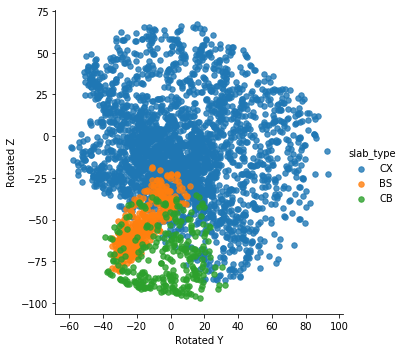

In [9]:
test = pandas.DataFrame(new_coords[:,:,90],columns=['y','z','x'])
test.loc[:,'slab_type'] = gdf.loc[full_y.index,'slab_type'].values

sns.lmplot('y', 'z', hue = 'slab_type', data=test, 
           fit_reg=False, scatter_kws={"s": 30})
plt.xlabel('Rotated Y')
plt.ylabel('Rotated Z')


## Test run

In [10]:
# test run
rmod = PLSRegression(n_components=3,)
#rmod.fit(tr,new_coords[:,:,0])
rmod.fit(pca_tfm,new_coords[:,:,0])

PLSRegression(copy=True, max_iter=500, n_components=3, scale=True, tol=1e-06)

In [11]:
comp = pandas.DataFrame(np.concatenate([rmod.x_loadings_,
                                        orig_mod.x_loadings_,
                                       ],1),
                        columns = ['rot_y','rot_z','rot_x',
                                  'orig_y','orig_z','orig_x']
                       )
#sns.clustermap(comp)


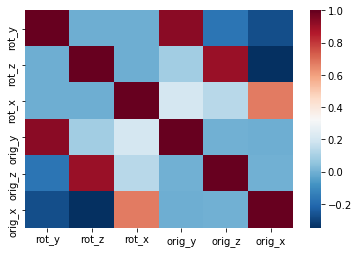

In [12]:
jnk = pandas.DataFrame(np.corrcoef(comp.T),
                       index = ['rot_y','rot_z','rot_x',
                                  'orig_y','orig_z','orig_x'],
                       columns = ['rot_y','rot_z','rot_x',
                                  'orig_y','orig_z','orig_x'])
sns.heatmap(jnk,cmap="RdBu_r")

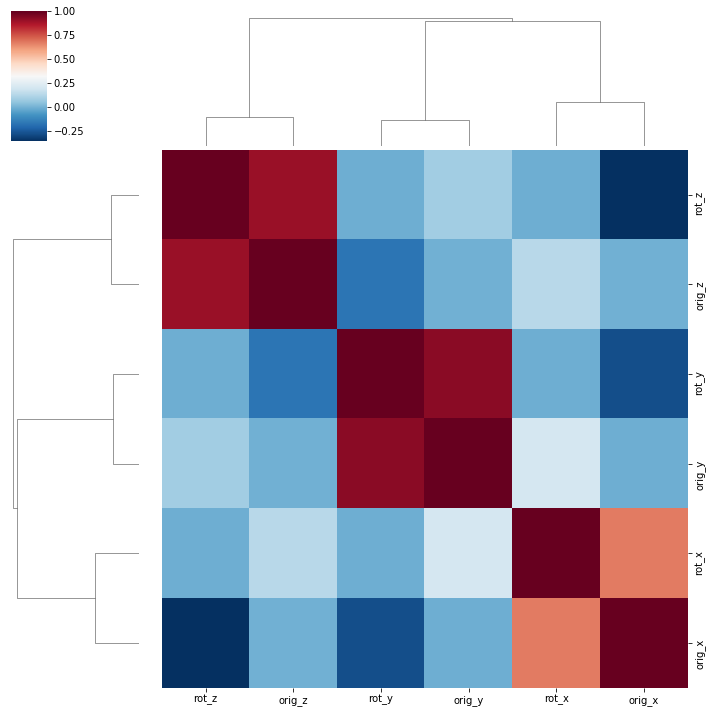

In [13]:
sns.clustermap(jnk,cmap="RdBu_r")

In [15]:
rmod = PLSRegression(n_components=3,)
rmod.fit(tr,simp_coords)
comp = pandas.DataFrame(np.concatenate([rmod.x_loadings_,
                                        orig_mod.x_loadings_,
                                        
                                       ],1),
                        columns = ['rot_y','rot_z','rot_x',
                                  'orig_y','orig_z','orig_x'])
jnk = pandas.DataFrame(np.corrcoef(comp.T),
                       index = ['rot_y','rot_z','rot_x',
                                  'orig_y','orig_z','orig_x'],
                       columns = ['rot_y','rot_z','rot_x',
                                  'orig_y','orig_z','orig_x'])
sns.heatmap(jnk,cmap="RdBu_r")

NameError: name 'tr' is not defined

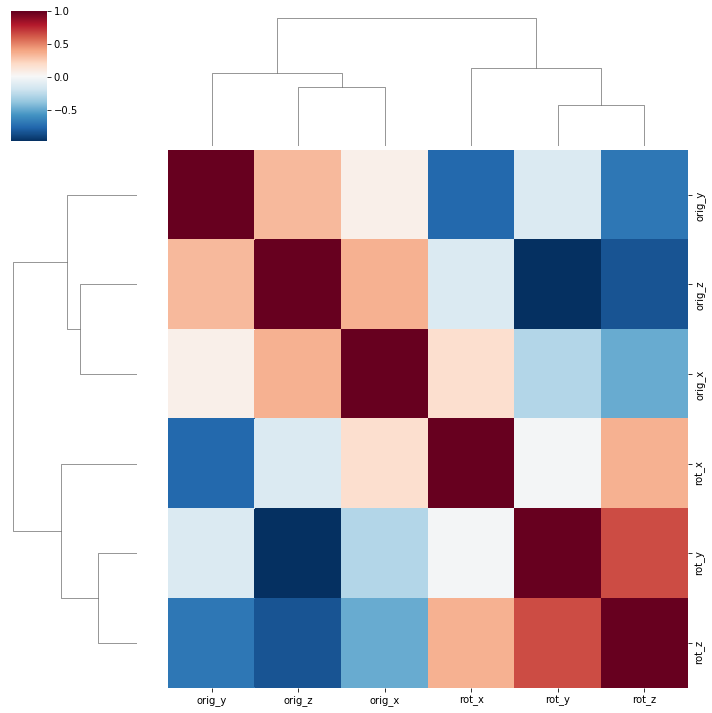

In [92]:
sns.clustermap(jnk,cmap="RdBu_r")

## Run analysis

In [ ]:
new_coo

In [10]:
loadings = pandas.DataFrame(orig_mod.x_loadings_,
                         columns = ['orig_C1','orig_C2','orig_C3'])
scores = pandas.DataFrame(index=range(n_rots),
                          columns = ['C1','C2','C3'])
compmap = pandas.DataFrame(index=range(n_rots),
                          columns = ['C1','C2','C3',
                                     'C1_r2','C2_r2','C3_r2']) 
for i in range(n_rots):
    print('Working on rotation',i)
    
    # fit model
    rmod = PLSRegression(n_components=3,)
    #rmod.fit(tr,new_coords[:,:,i])
    rmod.fit(pca_tfm,new_coords[:,:,i])
    
    # score
    pred = cross_val_predict(rmod,pca_tfm,new_coords[:,:,i],cv=10,
                      groups=gdf.loc[full_y.index,'slab_type'])
    scores.loc[i,'C1'] = stats.pearsonr(new_coords[:,0,i],
                                       pred[:,0])[0]**2
    scores.loc[i,'C2'] = stats.pearsonr(new_coords[:,1,i],
                                       pred[:,1])[0]**2
    scores.loc[i,'C3'] = stats.pearsonr(new_coords[:,2,i],
                                       pred[:,2])[0]**2
    scores.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/GCORR_Rotation_xval_score_full.csv')
    
    # compare
    comp = np.concatenate([orig_mod.x_loadings_,rmod.x_loadings_],1)
    comp = (np.corrcoef(comp.T)**2)[:3,3:]
    for k,v in dict(zip(['C1','C2','C3'],[0,1,2])).items():
        match = np.argmax(comp[v])
        compmap.loc[i,k] = match
        compmap.loc[i,'%s_r2'%k] = comp[v,match]
    compmap.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/GCORR_Rotation_matches_full.csv')
    
    # store
    loadings.loc[:,'r%s_C1'%i] = rmod.x_loadings_[:,0]
    loadings.loc[:,'r%s_C2'%i] = rmod.x_loadings_[:,1]
    loadings.loc[:,'r%s_C3'%i] = rmod.x_loadings_[:,2]
    loadings.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/GCORR_loadings_full.csv')
    

Working on rotation 0
Working on rotation 1
Working on rotation 2
Working on rotation 3
Working on rotation 4
Working on rotation 5
Working on rotation 6
Working on rotation 7
Working on rotation 8
Working on rotation 9
Working on rotation 10
Working on rotation 11
Working on rotation 12
Working on rotation 13
Working on rotation 14
Working on rotation 15
Working on rotation 16
Working on rotation 17
Working on rotation 18
Working on rotation 19
Working on rotation 20
Working on rotation 21
Working on rotation 22
Working on rotation 23
Working on rotation 24
Working on rotation 25
Working on rotation 26
Working on rotation 27
Working on rotation 28
Working on rotation 29
Working on rotation 30
Working on rotation 31
Working on rotation 32
Working on rotation 33
Working on rotation 34
Working on rotation 35
Working on rotation 36
Working on rotation 37
Working on rotation 38
Working on rotation 39
Working on rotation 40
Working on rotation 41
Working on rotation 42
Working on rotation 4

In [8]:
loadings = pandas.read_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/GCORR_loadings_full.csv',
                       index_col=0)
compmap = pandas.read_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/GCORR_Rotation_matches_full.csv',
                          index_col=0)
scores = pandas.read_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/GCORR_Rotation_xval_score_full.csv',
                        index_col=0)
#rotdf = pandas.read_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Rotations.csv',
#                       index_col=0)

In [9]:
from math import sqrt

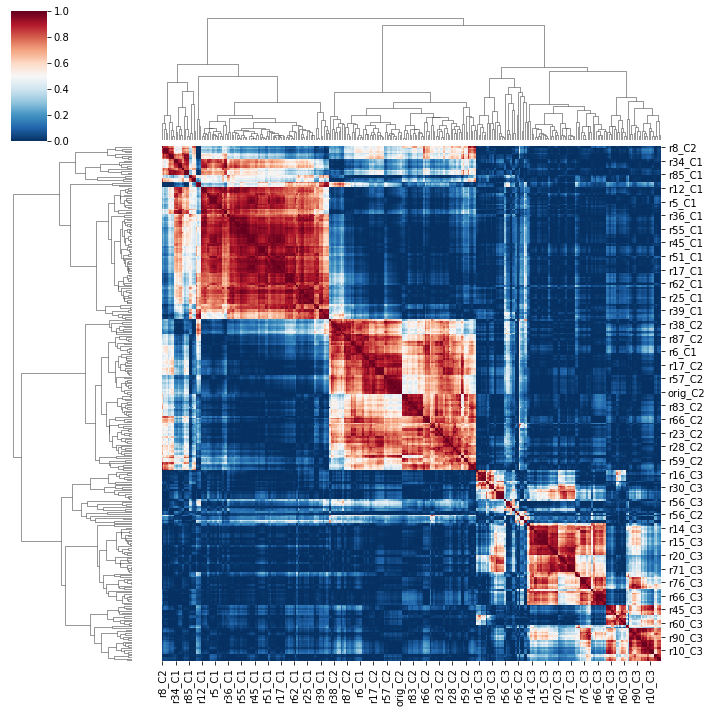

In [14]:
jnk = pandas.DataFrame((np.corrcoef(loadings.T)**2),
                      index=loadings.columns,
                      columns=loadings.columns)
g = sns.clustermap(jnk,cmap='RdBu_r')
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/Loadings_clusters.pdf',
          bbox_inches='tight')

In [15]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

In [24]:
# ks = range(2,10)
# solutions = pandas.DataFrame(index = ks, 
#                              columns = ['silhouette', 'CH_index'])
# X = loadings.T
# connectivity = kneighbors_graph(X, n_neighbors=100)
# for k in ks:
#     clusterer = AgglomerativeClustering(n_clusters=k, 
#                                         connectivity=connectivity)
#     cluster_labels = clusterer.fit_predict(X)
#     # silhouette
#     solutions.loc[k,'silhouette'] = silhouette_score(X, 
#                                                  cluster_labels)
#     # CH Index
#     solutions.loc[k,'CH_index'] = calinski_harabasz_score(X, 
#                                                  cluster_labels)
#     mtx = pandas.DataFrame(betas.T.values, copy=True)
#     mtx.loc[:,'label'] = cluster_labels
#     print('finished',k)
# solutions.loc[:,'k'] = solutions.index

In [25]:
# plt.close()
# sns.factorplot(x='k',y='silhouette',data=solutions)
# plt.show()

In [52]:
dendrogram.keys()

dict_keys(['dcoord', 'leaves', 'color_list', 'icoord', 'ivl'])

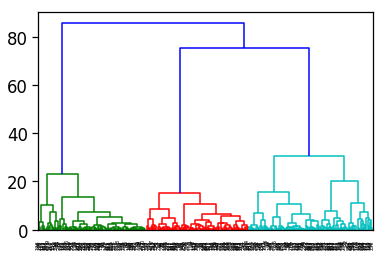

In [53]:
import scipy.cluster.hierarchy as sch
X = loadings.T
dendrogram = sch.dendrogram(sch.linkage((np.corrcoef(loadings.T)**2), 
                                        method='ward'))
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/RotDendogram.pdf',
          bbox_inches='tight')


In [27]:
clusterer = AgglomerativeClustering(n_clusters=3,linkage='ward')
X = (np.corrcoef(loadings.T)**2)
cluster_labels = clusterer.fit_predict(X)
mtx = pandas.DataFrame(X, copy=True,
                      index = loadings.columns, columns=loadings.columns)
mtx.loc[:,'label'] = cluster_labels

In [29]:
mtx.loc[:,'comp'] = [x[-2:] for x in mtx.index]

In [42]:
confus[[1,2,0]]

label,1,2,0
comp,,,
C1,94,7,0
C2,4,86,11
C3,0,0,101


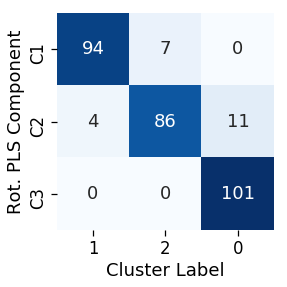

In [54]:
sns.set_context('notebook',font_scale=1.5)
confus = pandas.crosstab(index=mtx.comp,columns=mtx['label'])
g = sns.heatmap(confus[[1,2,0]].round(0),cmap='Blues',
                annot=True,fmt='g',cbar=False,square=True)
g.set_xlabel('Cluster Label')
g.set_ylabel('Rot. PLS Component')
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/Rot_ConfusMat.pdf',
          bbox_inches='tight')

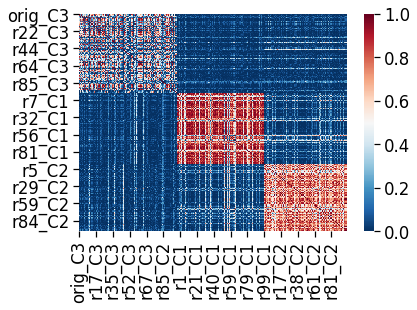

In [63]:
order = mtx[mtx.label==0].index.tolist() +\
        mtx[mtx.label==1].index.tolist() +\
        mtx[mtx.label==2].index.tolist()
sns.heatmap(mtx.loc[order,order],cmap='RdBu_r')

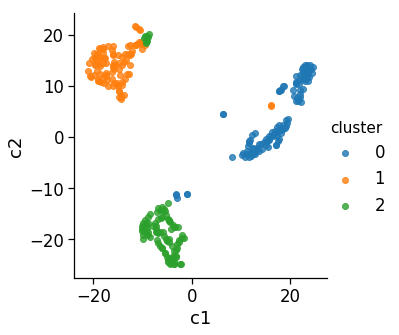

In [64]:
from sklearn.manifold import TSNE

tstmod = TSNE(random_state=123)
#testpc = tstmod.fit((np.corrcoef(betas.T)**2))
testpc = tstmod.fit(X)

tstplot = pandas.concat([pandas.Series(testpc.embedding_[:,0]),
                         pandas.Series(testpc.embedding_[:,1]),
                         pandas.Series(cluster_labels)],
                        axis=1)
tstplot.columns=['c1','c2','cluster']

sns.lmplot('c1','c2',hue='cluster',
           data=tstplot,
            fit_reg=False)

In [65]:
mtx[mtx.label==0].index.tolist()

1

In [67]:
rotdf = pandas.DataFrame(rot,columns=['C1','C2','C3'])
rotdf.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/Rotations.csv')

In [68]:
compmap.columns = ['comp_%s'%x for x in compmap.columns]
rotdf.columns = ['rot_%s'%x for x in rotdf.columns]
scores.columns = ['xval_%s'%x for x in scores.columns]
allrot = pandas.concat([compmap,abs(rotdf),scores],axis=1)

In [107]:
allrot.columns

Index(['comp_y', 'comp_z', 'comp_x', 'comp_y_r2', 'comp_z_r2', 'comp_x_r2',
       'rot_y', 'rot_z', 'rot_x', 'xval_y', 'xval_z', 'xval_x'],
      dtype='object')

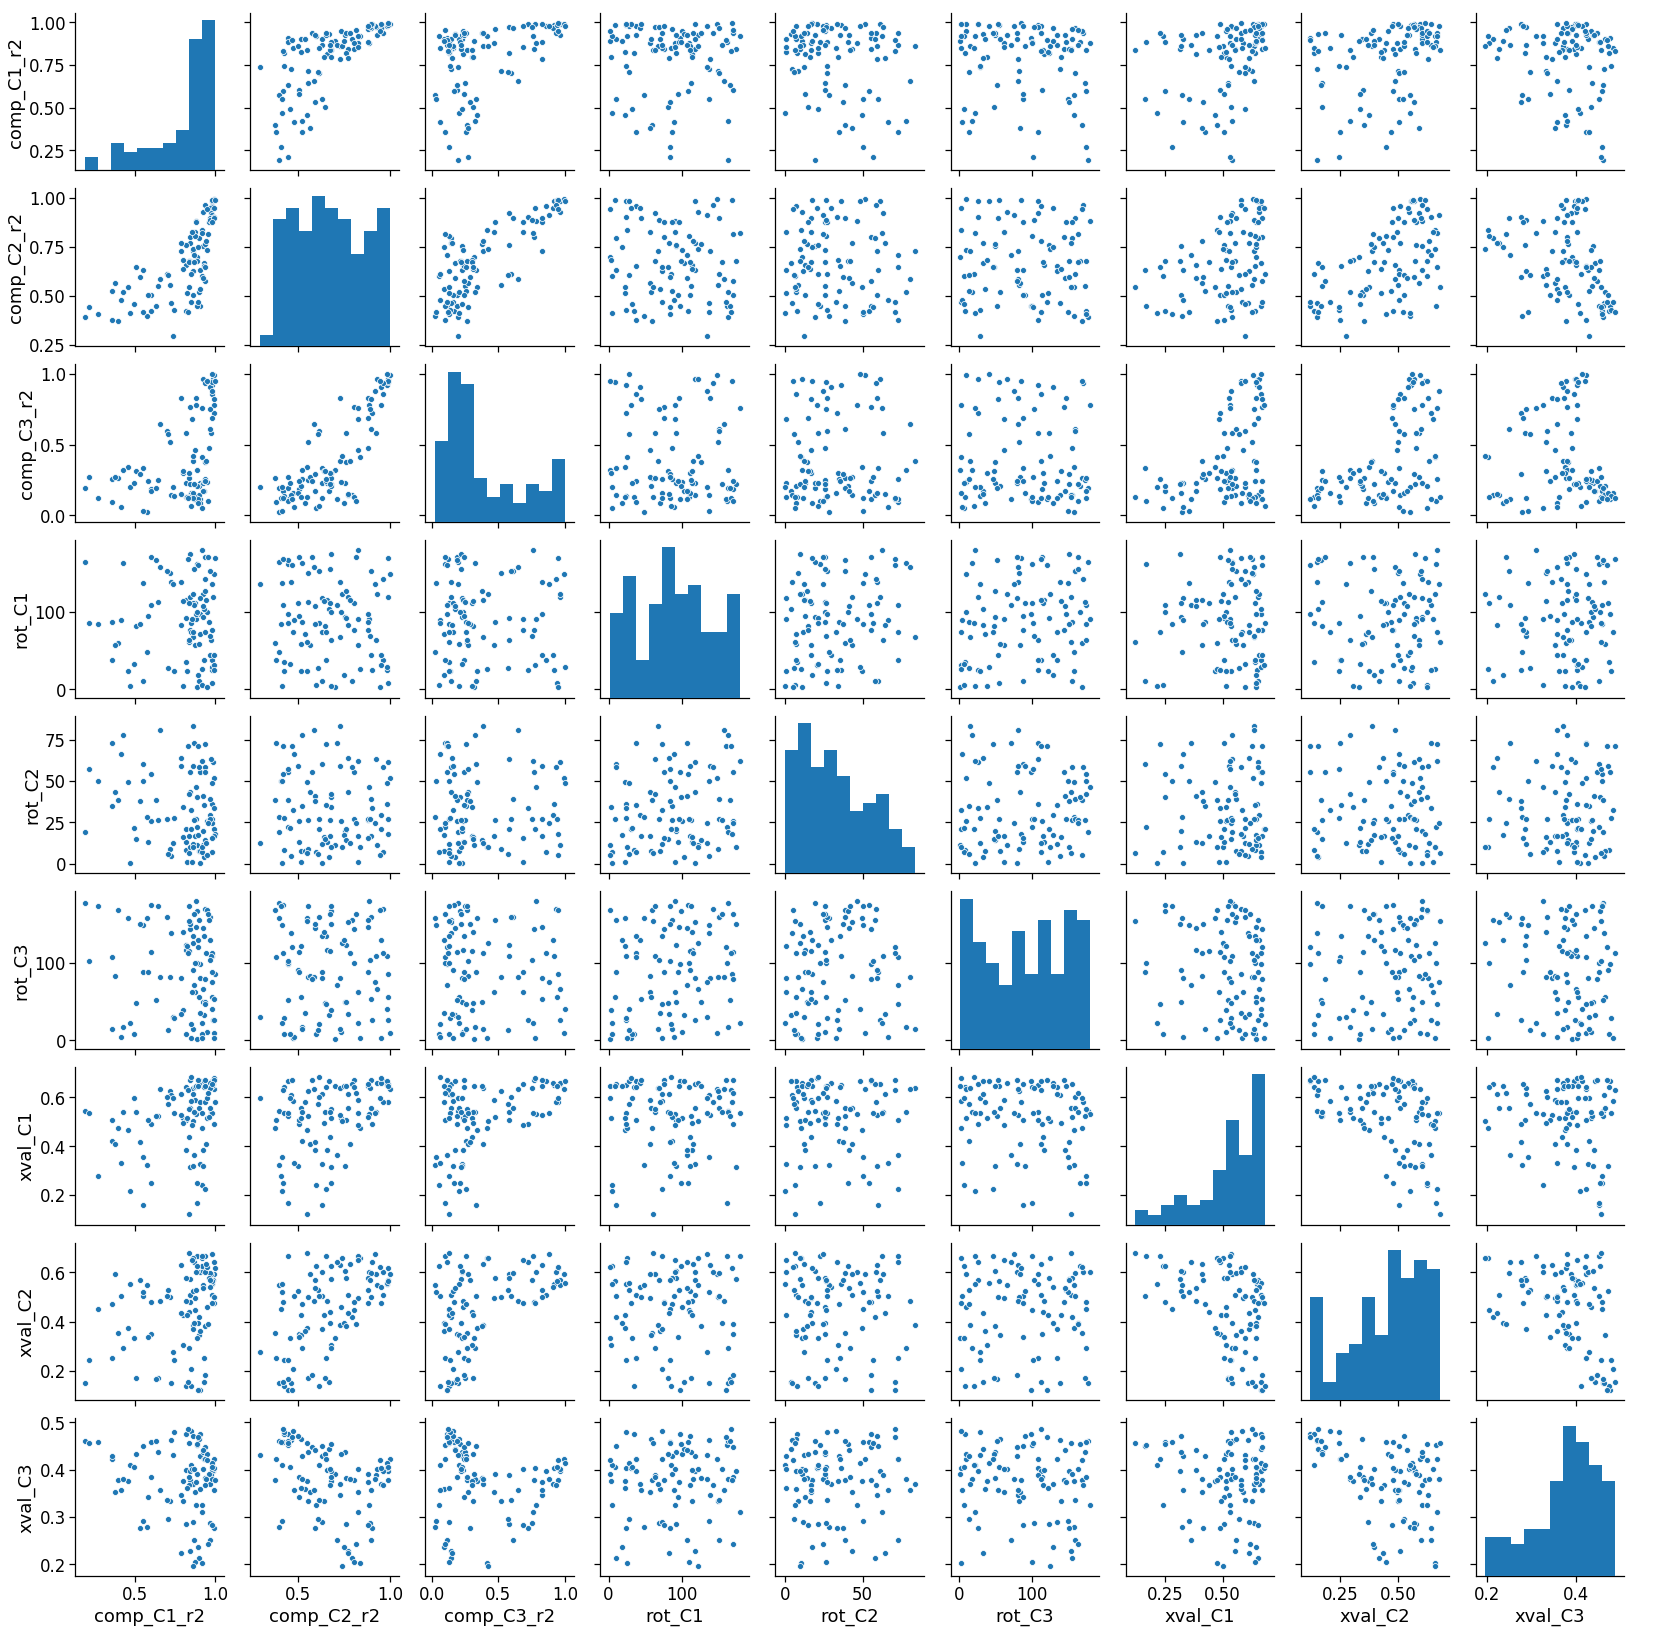

In [69]:
g = sns.pairplot(allrot[allrot.columns[3:]], 
                 diag_kind="auto")

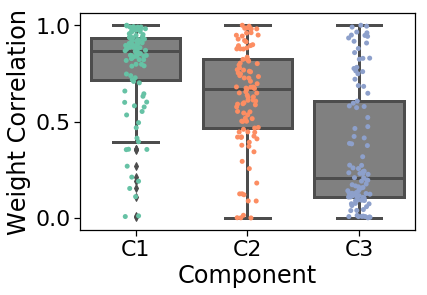

In [41]:
sns.set_context('notebook',font_scale=2)
c1rs = [stats.pearsonr(loadings['orig_C1'],loadings[x])[0]**2 \
         for x in loadings.columns if '_C1' in x]
c2rs = [stats.pearsonr(loadings['orig_C2'],loadings[x])[0]**2 \
         for x in loadings.columns if '_C2' in x]
c3rs = [stats.pearsonr(loadings['orig_C3'],loadings[x])[0]**2 \
         for x in loadings.columns if '_C3' in x]
vec1 = c1rs + c2rs + c3rs
vec2 = ['C1']*len(c1rs) + ['C2']*len(c2rs) + ['C3']*len(c3rs)
rcomps = pandas.concat([pandas.Series(vec2),pandas.Series(vec1)],axis=1)
rcomps.columns = ['Component','Weight Correlation']
sns.stripplot(x='Component',y='Weight Correlation',data=rcomps,
              palette='Set2')
sns.boxplot(x='Component',y='Weight Correlation',data=rcomps,
            color='gray',linewidth=3)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/Rot_WeighCorrs.pdf',
          bbox_inches='tight')

In [40]:
for comp in rcomps.Component.unique():
    print(np.median(rcomps[rcomps.Component==comp]['Weight Correlation']))

0.8646624001853025
0.6685873253477593
0.20812760658124202


# Find most invariant loadings

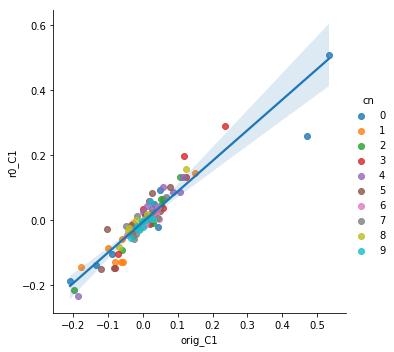

In [10]:
loadings.loc[:,'comp'] = range(len(loadings))
cn = []
for i in range(10):
    cn += [i]*10
loadings.loc[:,'cn'] = cn
#loadings.loc[:,'cluster'] = cluster_labels
sns.lmplot('orig_C1','r0_C1',data=loadings,hue='cn',fit_reg=False)
sns.regplot('orig_C1','r0_C1',data=loadings,marker='')


In [11]:
ys = loadings[[x for x in loadings.columns if '_C1' in x]]
means = ys.mean(1)
sems = ys.sem(1)

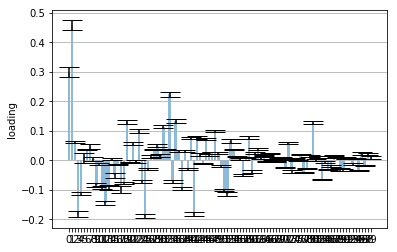

In [28]:
fig, ax = plt.subplots()
x_pos = np.arange(len(means))
ax.bar(x_pos, means, 
       yerr=sems, 
       #yerr=ys.std(1),
       align='center', alpha=0.5, ecolor='black', 
       capsize=10)
ax.set_ylabel('loading')
ax.set_xticks(x_pos)
#ax.set_xticklabels(materials)
#ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
ax.yaxis.grid(True)

# Save the figure and show
# plt.tight_layout()
# plt.savefig('bar_plot_with_error_bars.png')
plt.show()

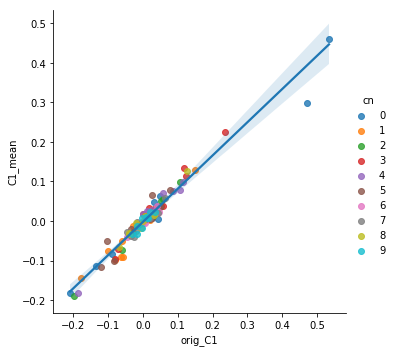

In [29]:
loadings.loc[:,'C1_mean'] = means
loadings.loc[:,'comp'] = range(len(loadings))
cn = []
for i in range(10):
    cn += [i]*10
loadings.loc[:,'cn'] = cn
#loadings.loc[:,'cluster'] = cluster_labels
sns.lmplot('orig_C1','C1_mean',data=loadings,hue='cn',fit_reg=False)
sns.regplot('orig_C1','C1_mean',data=loadings,marker='')

In [30]:
newc1 = np.dot(pcamod.components_.T, means)
newc1 = pandas.concat([pandas.Series(newc1), 
                       probes[['gene_symbol','gene_name']]], axis=1)

In [31]:
newc1.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/GCORR_RotAvg_C1_full.csv')

In [33]:
newc1.sort_values(0,ascending=False).dropna()

,0,gene_symbol,gene_name
7492,0.036935,BTG2,"BTG family, member 2"
12808,0.035242,STK36,serine/threonine kinase 36
7856,0.033818,MPZL1,myelin protein zero-like 1
1245,0.032145,DYNC1I2,"dynein, cytoplasmic 1, intermediate chain 2"
1865,0.031039,GNG3,guanine nucleotide binding protein (G protein)...
12899,0.030574,NRBF2,nuclear receptor binding factor 2
13662,0.029746,ASB4,ankyrin repeat and SOCS box containing 4
7936,0.029219,CNTNAP1,contactin associated protein 1
5981,0.028925,SLPI,secretory leukocyte peptidase inhibitor
9428,0.028158,SV2A,synaptic vesicle glycoprotein 2A


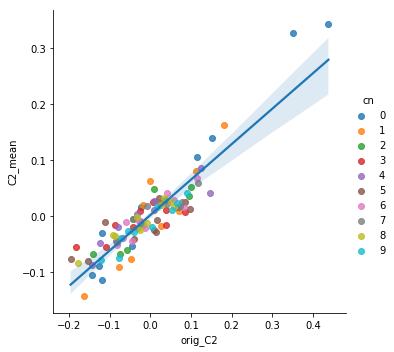

In [34]:
zs = loadings[[x for x in loadings.columns if '_C2' in x]]
means = zs.mean(1)
sems = zs.sem(1)
loadings.loc[:,'C2_mean'] = means
newc2 = np.dot(pcamod.components_.T, means)
newc2 = pandas.concat([pandas.Series(newc2), 
                       probes[['gene_symbol','gene_name']]], 
                      axis=1)
loadings.loc[:,'comp'] = range(len(loadings))
#loadings.loc[:,'cluster'] = cluster_labels
sns.lmplot('orig_C2','C2_mean',data=loadings,hue='cn',fit_reg=False)
sns.regplot('orig_C2','C2_mean',data=loadings,marker='')

In [35]:
newc2.sort_values(0,ascending=False).head()

,0,gene_symbol,gene_name
14227,0.028543,ASPN,asporin
2114,0.026253,GP2,glycoprotein 2 (zymogen granule membrane)
5500,0.026115,RPL23A,ribosomal protein L23a
10552,0.025144,CA5B,"carbonic anhydrase VB, mitochondrial"
10446,0.024387,C9orf9,chromosome 9 open reading frame 9


In [36]:
newc2.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/GCORR_RotAvg_C2_full.csv')

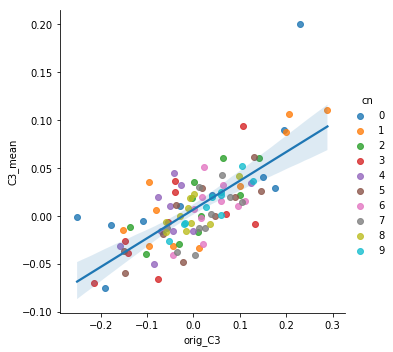

In [37]:
xs = loadings[[x for x in loadings.columns if '_C3' in x]]
means = xs.mean(1)
sems = xs.sem(1)
loadings.loc[:,'C3_mean'] = means
newc3 = np.dot(pcamod.components_.T, means)
newc3 = pandas.concat([pandas.Series(newc3), 
                       probes[['gene_symbol','gene_name']]], 
                      axis=1)
loadings.loc[:,'comp'] = range(len(loadings))
#loadings.loc[:,'cluster'] = cluster_labels
sns.lmplot('orig_C3','C3_mean',data=loadings,hue='cn',fit_reg=False)
sns.regplot('orig_C3','C3_mean',data=loadings,marker='')

In [38]:
newc3.sort_values(0,ascending=False).head()

,0,gene_symbol,gene_name
8650,0.019292,BUB3,budding uninhibited by benzimidazoles 3 homolo...
4803,0.015343,PGF,placental growth factor
11055,0.013909,FAM179B,"family with sequence similarity 179, member B"
379,0.013702,CACNG1,"calcium channel, voltage-dependent, gamma subu..."
7861,0.013399,SOCS3,suppressor of cytokine signaling 3


In [39]:
newc3.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/GCORR_C3_full.csv')

### Do a BS ratio kind of thing

In [84]:
n_feats_x = pca_tfm.shape[-1]
n_feats_y = full_y.shape[-1]
bs_ratio_x = pandas.DataFrame(index = range(orig_mod.n_components),
                                columns = range(n_feats_x))
all_results_x = {}
for i in range(orig_mod.n_components):
    cols = [x for x in loadings.columns if '_C%s'%(i+1) in x]
    all_results_x.update({i:loadings[cols].T})

bs_ratio_x = XD.bootstrap_ratio(all_results_x, bs_ratio_x)

In [88]:
bs_ratio_x.keys()

dict_keys(['bsr', 'se', 'p', 'mean'])

In [118]:
bs_ratio_x['p']

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.00990099,0.00990099,0.207921,0.128713,0.00990099,0.00990099,0.158416,0.534653,0.00990099,0.029703,...,0.29703,0.178218,0.128713,0.178218,0.247525,0.287129,0.475248,0.425743,0.0891089,0.267327
1,0.207921,0.188119,0.247525,0.227723,0.247525,0.247525,0.207921,0.217822,0.415842,0.188119,...,0.475248,0.455446,0.188119,0.207921,0.475248,0.306931,0.217822,0.425743,0.207921,0.39604
2,0.148515,0.425743,0.386139,0.465347,0.346535,0.415842,0.158416,0.237624,0.316832,0.19802,...,0.188119,0.386139,0.237624,0.376238,0.544554,0.287129,0.178218,0.554455,0.237624,0.237624


In [91]:
plotr = pandas.concat([pandas.Series(all_results_x[0].values.flatten()),
                       pandas.Series(list(range(100))*101)],
                      axis=1)
plotr.columns = ['Loading','Component']

Text(0, 0.5, 'PLS X Score 1 Loading')

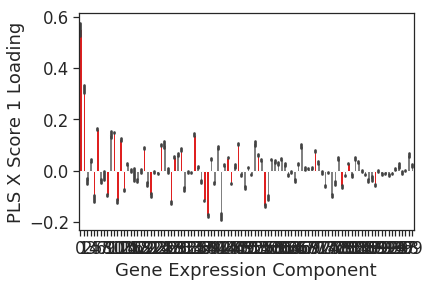

In [92]:
sns.set(font_scale=1.5)
sns.set_style('ticks')
colors = ['Red' if x else 'Grey' for x in multipletests(bs_ratio_x['p'].loc[0], method='fdr_bh')[0]]
sns.barplot(x='Component', y='Loading', data=plotr, palette=colors)
plt.xlabel('Gene Expression Component')
plt.ylabel('PLS X Score 1 Loading')
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/figs/C1_x_loadings.pdf',
#           bbox_inches='tight')
#g.set_xticklabels([None for x in range(100)])
#plt.xticks(['' for x in range(100)])

In [100]:
sigs = multipletests(bs_ratio_x['p'].loc[0], method='fdr_bh')[0]
new_loading = [all_results_x[0].mean()[x] if sigs[x] else 0 for x in range(pca_tfm.shape[-1])]
bs_c1 = np.dot(pcamod.components_.T, new_loading)
bs_c1 = pandas.concat([pandas.Series(bs_c1), probes[['gene_symbol','gene_name']]], axis=1)

Text(0, 0.5, 'Rotation average')

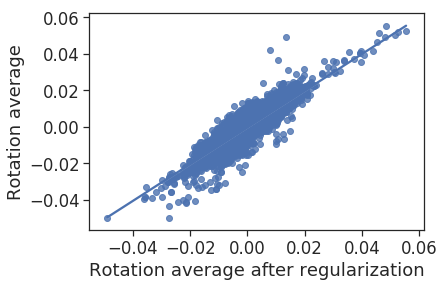

In [107]:
sns.regplot(bs_c1[0],newc1[0])
plt.xlabel('Rotation average after regularization')
plt.ylabel('Rotation average')

In [108]:
bs_c1.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/RotAvg_C1_full_bsr.csv')

Text(0, 0.5, 'PLS X Score 2 Loading')

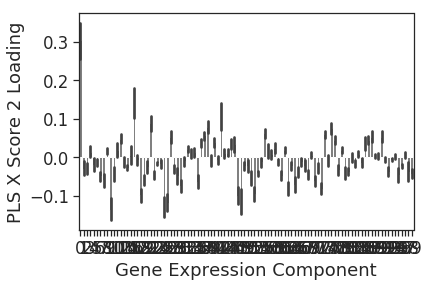

In [117]:
plotr = pandas.concat([pandas.Series(all_results_x[2].values.flatten()),
                       pandas.Series(list(range(100))*101)],
                      axis=1)
plotr.columns = ['Loading','Component']
colors = ['Red' if x else 'Grey' for x in multipletests(bs_ratio_x['p'].loc[2], method='fdr_bh')[0]]
sns.barplot(x='Component', y='Loading', data=plotr, palette=colors)
plt.xlabel('Gene Expression Component')
plt.ylabel('PLS X Score 2 Loading')

In [109]:
sigs = multipletests(bs_ratio_x['p'].loc[1], method='fdr_bh')[0]
new_loading = [all_results_x[1].mean()[x] if sigs[x] else 0 for x in range(pca_tfm.shape[-1])]
bs_c2 = np.dot(pcamod.components_.T, new_loading)
bs_c2 = pandas.concat([pandas.Series(bs_c2), probes[['gene_symbol','gene_name']]], axis=1)

Text(0, 0.5, 'Rotation average')

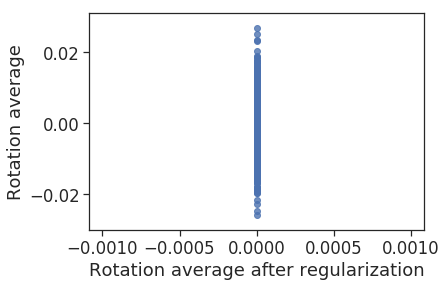

In [110]:
sns.regplot(bs_c2[0],newc2[0])
plt.xlabel('Rotation average after regularization')
plt.ylabel('Rotation average')

In [11]:
newc1 = pandas.read_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/RotAvg_C1.csv',
                        index_col=0)
newc2 = pandas.read_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/RotAvg_C2.csv',
                       index_col=0)
newc3 = pandas.read_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/RotAvg_C3.csv',
                        index_col=0)

In [15]:
newc1.columns[0]

'0'

In [42]:
c1_xp = hap.get_gene_vector(pandas.DataFrame(bigdf.T), newc1['0'])
c2_xp = hap.get_gene_vector(pandas.DataFrame(bigdf.T), newc2['0'])
c3_xp = hap.get_gene_vector(pandas.DataFrame(bigdf.T), newc3['0'])

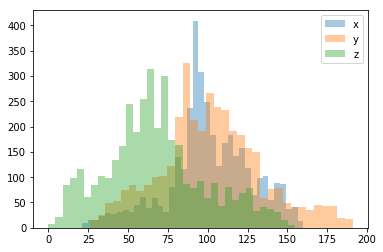

In [38]:
jnk = np.array([list(x) for x in input_coords])
sns.distplot(jnk[:,0],kde=False,label='x')
sns.distplot(jnk[:,1],kde=False,label='y')
sns.distplot(jnk[:,2],kde=False,label='z')
plt.legend()
plt.show()

In [18]:
input_coords = []
for i,row in gdf.iterrows():
    input_coords.append(hap.convert_coords([round(int(row['mni_nlin_x'])), 
                                        round(int(row['mni_nlin_y'])), 
                                        round(int(row['mni_nlin_z']))], 'xyz'))
mni_pth = '/home/users/jvogel/Science/templates/templates/MNI152_T1_1mm_brain.nii'
wdir = '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/'

In [19]:
nm = 'NEUR608_IMG_c1'
gcx_img1 = hap.make_expression_image(c1_xp, input_coords, mni_pth, wdir, nm, 5, return_img=True)
nm = 'NEUR608_IMG_c2'
gcx_img2 = hap.make_expression_image(c2_xp, input_coords, mni_pth, wdir, nm, 5, return_img=True)
nm = 'NEUR608_IMG_c3'
gcx_img3 = hap.make_expression_image(c3_xp, input_coords, mni_pth, wdir, nm, 5, return_img=True)

In [46]:
dat = gcx_img2.get_fdata()
dat[:,:,175:][dat[:,:,175:]>0]

array([], dtype=float64)

In [63]:
from nilearn import image
img_dict =  {'smth_1_0' :gcx_img1,
            'smth_1_4' :image.smooth_img(gcx_img1,4),
            'smth_1_8' :image.smooth_img(gcx_img1,8),
            
            'smth_2_4' :image.smooth_img(gcx_img2,4),
            'smth_2_8' :image.smooth_img(gcx_img2,8),
            'smth_3_0' :gcx_img3,
            'smth_3_4' :image.smooth_img(gcx_img3,4),
            'smth_3_8' :image.smooth_img(gcx_img3,8),}

In [74]:
jnk = img_dict['smth_3_4'].get_fdata()

In [78]:
# for c,img in enumerate([gcx_img1,gcx_img2,gcx_img3,]):
#     img.to_filename('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/PLS_Volume_C%s_Smth0mm.nii.gz'%(c+1))
#     for s in [4,8]:
#         smth = image.smooth_img(img,s)
#         sdat = smth.get_fdata()
#         sdat = sdat.astype(np.float16)
#         nsmth = ni.Nifti1Image(sdat, smth.affine)
#         nsmth.to_filename('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/PLS_Volume_C%s_Smth%smm.nii.gz'%((c+1),s))

In [64]:
for nm,img in img_dict.items():
    _,comp,smth = nm.split('_')
    img.to_filename('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/PLS_Volume_C%s_Smth%smm'%(comp,smth))

/home/users/jvogel/gxp/lib/python3.5/site-packages/nilearn/reporting/html_document.py:60: UserWarning:

It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.




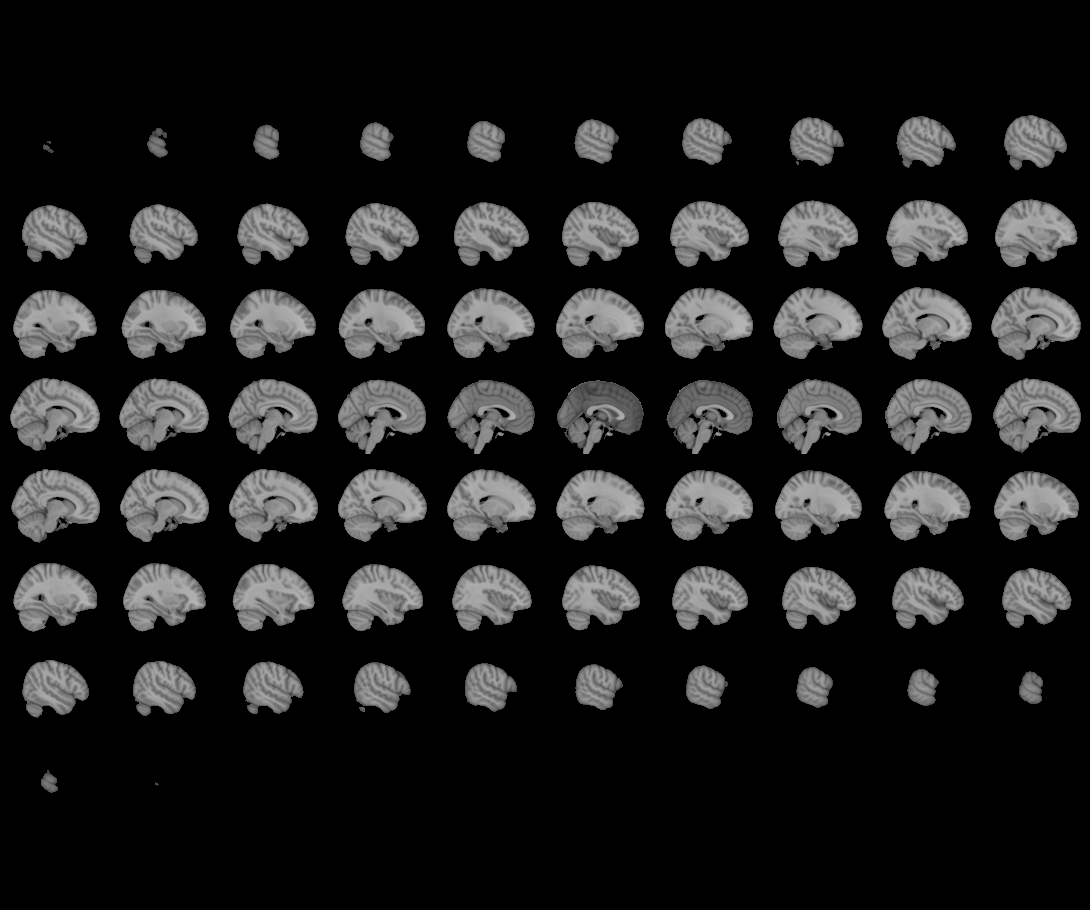
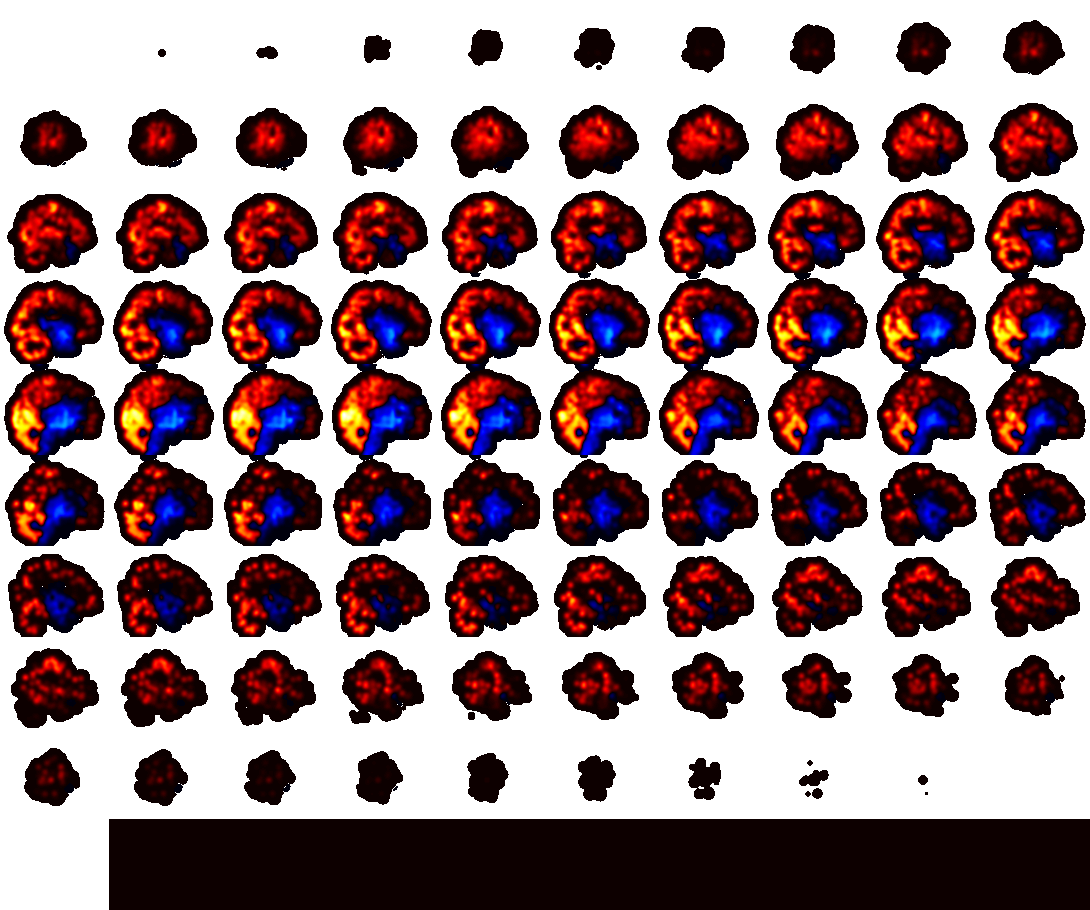

In [60]:
plotting.view_img(smth2_8)

# Murray PLS Check

# BrainSmash

In [8]:
### Prep data
bs_inputs = {'gxp': bigdf, 'PCs': pca_tfm, 'Ys': full_y}

In [42]:
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler
distmat = cdist(full_y.round(4).values,full_y.round(4).values)

In [16]:
bs_inputs.update({'dist':distmat})

In [17]:
pandas.to_pickle(bs_inputs,
                 '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ADDX/BrainSmash_input.pk')

In [17]:
(1000 * 4.34) / 32

135.625

In [10]:
from brainsmash.mapgen.base import Base

def brainsmash_pipeline(dat, dist, indx, outdir, outnm='', n_iter=1000, 
                        start_at=0):
    vec = dat.iloc[:,indx].values
    base = Base(x=vec,D=dist)
    surrogates = base(n=n_iter)
    fnm = os.path.join(outdir,'%s_%s-%s'%(outnm,indx,start_at))
    np.savez_compressed(fnm,surrogates)

In [13]:
import datetime
start = datetime.datetime.now()
print('started at',start)
outdir = '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/surrogates/'
brainsmash_pipeline(pca_tfm,distmat,0,outdir,'PC',10)
end = datetime.datetime.now()
print('ended at',end)
print('duration:', end - start)

started at 2020-09-07 00:29:45.957701
ended at 2020-09-07 00:34:20.564546
duration: 0:04:34.606845


In [43]:
done = sorted(glob('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/surrogates/*'))
done = [int(x.split('_')[-1].split('-')[0]) if '-' in x else\
        int(x.split('_')[-1].split('.')[0]) for x in done]

In [44]:
len(np.unique(done))

100

In [46]:
outdir = '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/surrogates/'

In [14]:
outdir = '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/surrogates/'
for idx in range(100):
    if idx in done: 
        if done.count(idx) == 10: 
            continue
        elif done.count(idx) == 1:
            continue
        else:
            nstart = done.count(idx) * 10
    else:
        nstart = 0
    for start in range(nstart,100,10):
        print('working on PC%s, iteration %s'%(idx,start))
        brainsmash_pipeline(pca_tfm,distmat,idx,outdir,'PC',10,start)
            

In [47]:
surrogates = sorted(glob(os.path.join(outdir,'*')))
#surrogates

In [48]:
null_results = pandas.DataFrame(np.zeros((100,3)))
for i in range(100):
    if i % 10 == 0: print('working on iteration',i)
    comp_mat = np.zeros_like(pca_tfm)
    for comp in range(100):
        if done.count(comp) == 1:
            arr = np.load(os.path.join(outdir,'PC_%s.npz'%comp))['arr_0']
            vec = arr[i]
        elif done.count(comp) == 10:
            interval = int(i/10) * 10
            remainder = i%10
            arr = np.load(os.path.join(outdir,'PC_%s-%s.npz'%(comp,
                                                              interval))
                         )['arr_0']
            vec = arr[remainder]
        comp_mat[:,comp] = vec
    surr_mod = PLSRegression(n_components=3)
    #orig_mod.fit(tr,tr_y)
    surr_mod.fit(comp_mat,full_y)
    scores = [stats.pearsonr(surr_mod.x_scores_[:,x], surr_mod.y_scores_[:,x]
                                         )[0]**2 for x in range(3)]
    null_results.loc[i,:] = scores

working on iteration 0
working on iteration 10
working on iteration 20
working on iteration 30
working on iteration 40
working on iteration 50
working on iteration 60
working on iteration 70
working on iteration 80
working on iteration 90


In [49]:
null_results = null_results.stack().reset_index()
null_results.columns = ['iteration','component','score']
null_results.loc[:,'model'] = 'Brainsmash_Null'

In [50]:
orig_mod = PLSRegression(n_components=3)
#orig_mod.fit(pca_tfm,full_y)
results, comp_sig = XD.evaluate_components(orig_mod, pca_tfm,
                                           full_y, n_iterations=100,
                                          plot=False)

finished iteration 0
component 0: p = 0.01  ***
component 1: p = 0.01  ***
component 2: p = 0.01  ***


In [90]:
n_iter = 100
n_comps = 3 
scores = pandas.DataFrame(index = range(n_iter*n_comps),
                          columns=['score','component'])
for i in range(n_iter):
#     trX,teX,trY,teY = train_test_split(pca_tfm,full_y,random_state=123+i,
#                                        shuffle=True,groups=gdf.slab_type)
    rs = np.random.RandomState(123+i)
    bsind = rs.choice(pca_tfm.index,len(pca_tfm),replace=True)
    bsX = pandas.DataFrame(pca_tfm.loc[bsind],copy=True)
    bsy = pandas.DataFrame(full_y.loc[bsind],copy=True)
    pmod = PLSRegression(n_components=3)
    pmod.fit(bsX,bsy)
    pscores = [stats.pearsonr(pmod.x_scores_[:,x], pmod.y_scores_[:,x]
                            )[0]**2 for x in range(n_comps)]
    scores.loc[(i*n_comps):((i*n_comps)+2),'score'] = pscores
    scores.loc[(i*n_comps):((i*n_comps)+2),'component'] = [0,1,2]

In [119]:
#all_results = pandas.concat([results,null_results,scores],sort=True)
scores.loc[:,'model'] = 'True'
null_results.loc[:,'model'] = 'Null (BrainSmash)'
results.loc[:,'model'] = 'Null (Naive)'
all_results = pandas.concat([results,null_results,scores],sort=True)

In [120]:
all_results.loc[:,'component'] = all_results.component.astype(str)

In [121]:
all_results.loc[:,'score'] = all_results.score.astype(float)

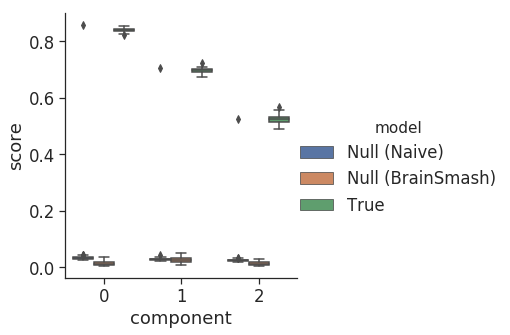

In [126]:
sns.catplot(x='component',y='score',hue='model',kind='box',
            data=all_results)

IndexError: index 2 is out of bounds for axis 0 with size 0

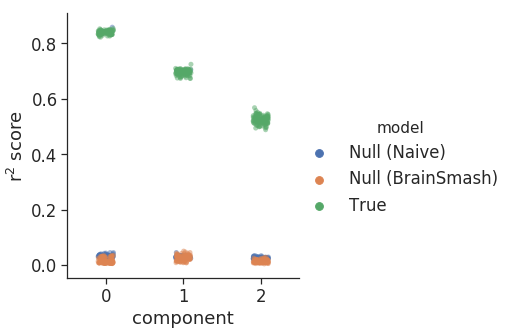

In [124]:
sns.set(font_scale=1.5)
sns.set_style('ticks')
sns.catplot(x='component', y='score', hue='model', data=all_results,
           alpha=0.5)
# plt.text(-0.20,0.9,'***')
# plt.text(0.80,0.7,'***')
# plt.text(1.80,0.53,'***')
plt.ylabel('r$^2$ score')
for c in range(len(all_results.component.unique())):
    cvals = all_results[(all_results.model=='Brainsmash_Null')&(all_results.component==c)
                ].score.sort_values().values
    cmin = cvals[2]
    cmax = cvals[98]
    plt.plot([c-.2,c+.2],[cmin,cmin],lw=2,c='green')
    plt.plot([c-.2,c+.2],[cmax,cmax],lw=2,c='green')
for c in range(len(all_results.component.unique())):
    cvals = all_results[(all_results.model=='Null')&(all_results.component==c)
                ].score.sort_values().values
    cmin = cvals[2]
    cmax = cvals[98]
    plt.plot([c-.2,c+.2],[cmin,cmin],lw=2,c='orange')
    plt.plot([c-.2,c+.2],[cmax,cmax],lw=2,c='orange')
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/sig_componentsTR.pdf',
#              bbox_inches='tight')

# Hansen et al. Autocorrelation Check

In [15]:
dm = pandas.DataFrame(distmat)

In [54]:
n_iter = 100
tr_size = 0.75

cut = int(round(len(full_y)*tr_size))
hansen = pandas.DataFrame()

spent = []
for i in range(n_iter):
    ind = np.random.choice(full_y.index)
    # to ensure we get no duplicates
    if ind in spent: 
        while ind in spent:
            ind = np.random.choice(full_y.index)
    spent.append(ind)
    
    source_dist = dm.loc[ind].sort_values()
    tr_idx = source_dist.index[:cut] 
    te_idx = source_dist.index[cut:]
    trX = pca_tfm.loc[tr_idx]
    teX = pca_tfm.loc[te_idx]
    trY = full_y.loc[tr_idx]
    teY = full_y.loc[te_idx]
    
    pls_mod = PLSRegression(n_components=3)
    pls_mod.fit(trX,trY)
    predicted = pls_mod.predict(teX)
    r2 = r2_score(teY,predicted)
    mae = mean_absolute_error(teY,predicted)
    
    hansen.loc[i,'idx'] = ind
    hansen.loc[i,'X'] = full_y.loc[ind,'abs_mni_nlin_x']
    hansen.loc[i,'Y'] = full_y.loc[ind,'mni_nlin_y']
    hansen.loc[i,'Z'] = full_y.loc[ind,'mni_nlin_z']
    hansen.loc[i,'dist_from_avg'] = source_dist.mean()
    hansen.loc[i,'slab'] = gdf.loc[ind,'slab_type']
    hansen.loc[i,'r2'] = r2
    hansen.loc[i,'mae'] = mae
    
    # control analysis
    tr_idx = np.random.choice(full_y.index,cut,replace=False)
    te_idx = [x for x in full_y.index if x not in tr_idx]
    trX = pca_tfm.loc[tr_idx]
    teX = pca_tfm.loc[te_idx]
    trY = full_y.loc[tr_idx]
    teY = full_y.loc[te_idx]
    
    pls_mod = PLSRegression(n_components=3)
    pls_mod.fit(trX,trY)
    predicted = pls_mod.predict(teX)
    r2 = r2_score(teY,predicted)
    mae = mean_absolute_error(teY,predicted)
    hansen.loc[i,'control_r2'] = r2
    hansen.loc[i,'control_mae'] = mae
    
    if i%10==0:
        print('finished iteration',i)

finished iteration 0
finished iteration 10
finished iteration 20
finished iteration 30
finished iteration 40
finished iteration 50
finished iteration 60
finished iteration 70
finished iteration 80
finished iteration 90


In [56]:
hansen.head()

,idx,X,Y,Z,dist_from_avg,slab,r2,mae,control_r2,control_mae
0,1898.0,22.751892,-11.699105,0.407854,45.986939,CX,0.320131,23.545494,0.705695,11.120720
1,1005.0,19.993910,55.181742,28.904705,92.552554,CX,-1.365567,26.936139,0.697233,10.994566
2,2953.0,56.732585,12.221885,-12.380856,65.140092,CX,-0.527469,25.263493,0.711373,10.847908
3,3211.0,24.032875,-22.115737,-1.558061,44.701782,CX,0.316352,23.626986,0.695076,11.350421
4,894.0,6.578928,-32.748441,-42.050153,58.869224,BS,-1.008583,31.100732,0.702438,10.950064


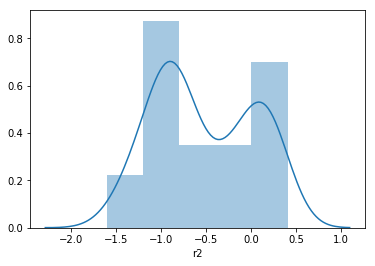

In [57]:
sns.distplot(hansen.r2)

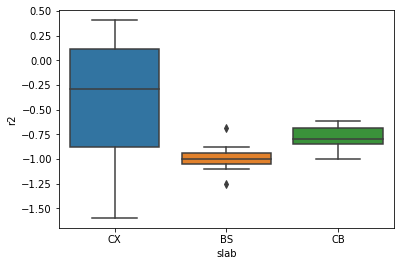

In [58]:
sns.boxplot(x='slab',y='r2',data=hansen)

In [64]:
hansen.loc[:,'brain_division'] = gdf.loc[hansen.idx,'brain_divison'].values

[Text(0, 0, 'Striatum'),
 Text(0, 0, 'Frontal'),
 Text(0, 0, 'Temporal'),
 Text(0, 0, 'Thalamus'),
 Text(0, 0, 'Medulla'),
 Text(0, 0, 'Hypothalamus'),
 Text(0, 0, 'Tegmentum'),
 Text(0, 0, 'Parietal'),
 Text(0, 0, 'Cerebellum'),
 Text(0, 0, 'Limbic'),
 Text(0, 0, 'Pons'),
 Text(0, 0, 'Insula'),
 Text(0, 0, 'Occipital'),
 Text(0, 0, 'Sensorimotor'),
 Text(0, 0, 'Anterior_Cingulate'),
 Text(0, 0, 'Forebrain'),
 Text(0, 0, 'DCN')]

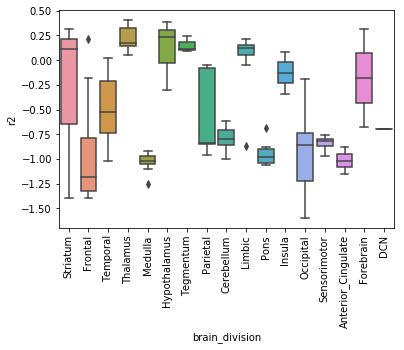

In [66]:
g = sns.boxplot(x='brain_division',y='r2',data=hansen)
g.set_xticklabels(g.get_xticklabels(),rotation=90)

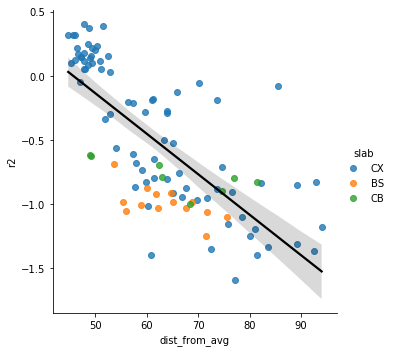

In [72]:
sns.lmplot(x='dist_from_avg',y='r2',data=hansen,hue='slab',
           fit_reg=False)
sns.regplot(x='dist_from_avg',y='r2',data=hansen,marker='',color='k')

In [34]:
n_iter = 100
tr_size = 0.75

cut = int(round(len(full_y)*tr_size))

ind = np.random.choice(full_y.index)
source_dist = dm.loc[ind].sort_values()
tr_idx = source_dist.index[:cut] 
te_idx = source_dist.index[cut:]

In [37]:
len(te_idx)

866

In [31]:
tr_idx

Index(['mni_nlin_z', 'mni_nlin_y', 'abs_mni_nlin_x'], dtype='object')

In [62]:
Medulla = ['arcuate nucleus of medulla, left','arcuate nucleus of medulla, right',
                 'central glial substance',
                 'central medullary reticular group, left','central medullary reticular group, right',
                 'cochlear nuclei, left','cochlear nuclei, right',
                 'cuneate nucleus, left','cuneate nucleus, right',
                 'dorsal motor nucleus of the vagus, left','dorsal motor nucleus of the vagus, right',
                 'gigantocellular group, left','gigantocellular group, right',
                 'gracile nucleus, left','gracile nucleus, right',
                 'hypoglossal nucleus, left','hypoglossal nucleus, right',
                 'inferior olivary complex, left','inferior olivary complex, right',
                 'lateral medullary reticular group, left','lateral medullary reticular group, right',
                 'raphe nuclei of medulla',
                 'spinal trigeminal nucleus, left','spinal trigeminal nucleus, right',
                 'superior olivary complex, left','superior olivary complex, right',
                 'vestibular nuclei, left','vestibular nuclei, right']

Pons =          ['abducens nucleus, left','abducens nucleus, right',
                 'central gray of the pons, left','central gray of the pons, right',
                 'facial motor nucleus, left','facial motor nucleus, right',
                 'lateral parabrachial nucleus, left','lateral parabrachial nucleus, right',
                 'locus ceruleus, left','locus ceruleus, right',
                 'medial parabrachial nucleus, left','medial parabrachial nucleus, right',
                 'medial parabrachial nucleus,right',
                 'motor nucleus of trigeminal nerve, left','motor nucleus of trigeminal nerve, right',
                 'nucleus subceruleus, left','nucleus subceruleus, right',
                 'pontine nuclei, left','pontine nuclei, right',
                 'pontine raphe nucleus','pontine raphe nucleus, left',
                 'pontine reticular formation, left','pontine reticular formation, right',
                 'principal sensory nucleus of trigeminal nerve, left','principal sensory nucleus of trigeminal nerve, right',
                 ]

DCN = ['dentate nucleus, left',
       'dentate nucleus, right',
       'emboliform nucleus, left',
       'emboliform nucleus, right',
       'fastigial nucleus, left',
       'fastigial nucleus, right',
       'globose nucleus, left',
       'globose nucleus, right']

Cerebellum = [x for x in gdf[gdf.slab_type=='CB']['structure_name'].unique().tolist() if x not in DCN]

Tectum = ['inferior colliculus, left',
          'superior colliculus, left','superior colliculus, right',
          'pretectal region']

Tegmentum = ['central gray substance of midbrain, left','central gray substance of midbrain, right',
            'cuneiform nucleus, left','cuneiform nucleus, right',
            'Edinger-Westphal nucleus, left','Edinger-Westphal nucleus, right',
            'interstitial nucleus of Cajal, left','interstitial nucleus of Cajal, right',
            'midbrain raphe nuclei','midbrain raphe nuclei, left',
            'midbrain reticular formation, left','midbrain reticular formation, right',
            'nucleus of Darkschewitsch, left',
            'oculomotor nuclear complex, right','oculomotor nuclear complex, left',
            'red nucleus, left','red nucleus, right',
            'subcuneiform nucleus, left','subcuneiform nucleus, right',
            'substantia nigra, pars compacta, left','substantia nigra, pars compacta, right',
            'substantia nigra, pars reticulata, left','substantia nigra, pars reticulata, right',
            'trochlear nucleus, left','trochlear nucleus, right',
            'ventral tegmental area, left','ventral tegmental area, right']

Hypothalamus = ['anterior hypothalamic area, left','anterior hypothalamic area, right',
               'arcuate nucleus of the hypothalamus, left','arcuate nucleus of the hypothalamus, right',
               'dorsomedial hypothalamic nucleus, left',
               'lateral hypothalamic area, anterior region, left', 'lateral hypothalamic area, anterior region, right',
               'lateral hypothalamic area, mammillary region, left', 'lateral hypothalamic area, mammillary region, right',
               'lateral hypothalamic area, tuberal region, left',
               'paraventricular nucleus of the hypothalamus, left','paraventricular nucleus of the hypothalamus, right',
               'perifornical nucleus, left',
               'posterior hypothalamic area, left','posterior hypothalamic area, right',
               'preoptic region, left','preoptic region, right',
               'supraoptic nucleus, left','supraoptic nucleus, right',
               'ventromedial hypothalamic nucleus, left','ventromedial hypothalamic nucleus, right',]
                

Thalamus = ['anterior group of nuclei, left','anterior group of nuclei, right',
           'caudal group of intralaminar nuclei, left','caudal group of intralaminar nuclei, right',
           'dorsal lateral geniculate nucleus, left','dorsal lateral geniculate nucleus, right',
           'lateral group of nuclei, left, dorsal division','lateral group of nuclei, left, ventral division',
           'lateral group of nuclei, right, dorsal division','lateral group of nuclei, right, ventral division',
           'medial geniculate complex, left','medial geniculate complex, right',
           'medial group of nuclei, left','medial group of nuclei, right',
           'reticular nucleus of thalamus, left','reticular nucleus of thalamus, right',
           'rostral group of intralaminar nuclei, left','rostral group of intralaminar nuclei, right',
           'paraventricular nuclei, left of thalamus, left','paraventricular nuclei, right of thalamus, right',
           'posterior group of nuclei, left','posterior group of nuclei, right',
           'subthalamic nucleus, left','subthalamic nucleus, right',
           'zona incerta, left','zona incerta, right']

Other_Dien = ['lateral habenular nucleus, left','lateral habenular nucleus, right',
             'lateral mammillary nucleus, left',
             'lateral tuberal nucleus, left',
             'mammillary body, left','mammillary body, right',
             'medial habenular nucleus, left','medial habenular nucleus, right',
             'medial mammillary nucleus, left',
             'pallidohypothalamic nucleus, left',
             'pineal gland',
             'supramammillary nucleus, left',
             'tuberomammillary nucleus, left']

Limbic = ['CA1 field, left','CA1 field, right',
          'CA2 field, left','CA2 field, right',
          'CA3 field, left','CA3 field, right',
          'CA4 field, left','CA4 field, right',
          'amygdalohippocampal transition zone, left',
          'amygdalohippocampal transition zone, right',
          'basolateral nucleus, left','basolateral nucleus, right',
          'basomedial nucleus, left','basomedial nucleus, right',
          'central nucleus, left','central nucleus, right',
          'cortico-medial group, left','cortico-medial group, right',
          'dentate gyrus, left','dentate gyrus, right',
          'lateral nucleus, left','lateral nucleus, right',
          'septal nuclei, left','septal nuclei, right',
         'subiculum, left','subiculum, right']

Forebrain = ['basal nucleus of meynert, left','basal nucleus of meynert, right',
            'nucleus accumbens, left','nucleus accumbens, right',
            'nucleus of the diagonal band, left, horizontal division',
            'nucleus of the diagonal band, left, vertical division',
            'olfactory tubercle, left', 'piriform cortex, left',
            'substantia innominata, left','substantia innominata, right']

Striatum = ['bed  nucleus of stria terminalis, left',
            'body of caudate nucleus, left',
            'body of caudate nucleus, right',
            'globus pallidus, external segment, left','globus pallidus, external segment, right',
            'globus pallidus, internal segment, left','globus pallidus, internal segment, right',
            'head of caudate nucleus, left','head of caudate nucleus, right',
            'olfactory tubercle, left',
            'putamen, left','putamen, right',
           'tail of caudate nucleus, left','tail of caudate nucleus, right']

Anterior_Cingulate = ['cingulate gyrus, frontal part, left, inferior bank of gyrus',
                     'cingulate gyrus, frontal part, left, superior bank of gyrus',
                     'cingulate gyrus, frontal part, right, inferior bank of gyrus',
                     'cingulate gyrus, frontal part, right, superior bank of gyrus',
                     'paraterminal gyrus, right',
                     'parolfactory gyri, left','parolfactory gyri, right',
                     'subcallosal cingulate gyrus, left','subcallosal cingulate gyrus, right']

Posterior_Cingulate = ['cingulate gyrus, parietal part, left, inferior bank of gyrus',
                     'cingulate gyrus, parietal part, left, superior bank of gyrus',
                     'cingulate gyrus, parietal part, right, inferior bank of gyrus',
                     'cingulate gyrus, parietal part, right, superior bank of gyrus',
                     'cingulate gyrus, retrosplenial part, left, inferior bank of gyrus',
                     'cingulate gyrus, retrosplenial part, left, superior bank of gyrus',
                     'cingulate gyrus, retrosplenial part, right, inferior bank of gyrus',
                     'cingulate gyrus, retrosplenial part, right, superior bank of gyrus',]

Insula = ['claustrum, left','claustrum, right',
         'long insular gyri, left','long insular gyri, right',
         'short insular gyri, left','short insular gyri, right',]

Temporal = ["Heschl's gyrus, left", "Heschl's gyrus, right",
           'fusiform gyrus, left, bank of cos','fusiform gyrus, left, bank of the its',
           'fusiform gyrus, left, lateral bank of gyrus','fusiform gyrus, right, bank of cos',
           'fusiform gyrus, right, bank of the its','fusiform gyrus, right, lateral bank of gyrus',
           'inferior temporal gyrus, left, bank of mts','inferior temporal gyrus, left, bank of the its',
           'inferior temporal gyrus, left, lateral bank of gyrus','inferior temporal gyrus, right, bank of mts',
           'inferior temporal gyrus, right, bank of the its','inferior temporal gyrus, right, lateral bank of gyrus',
           'middle temporal gyrus, left, inferior bank of gyrus','middle temporal gyrus, left, superior bank of gyrus',
           'middle temporal gyrus, right, inferior bank of gyrus','middle temporal gyrus, right, superior bank of gyrus',
           'occipito-temporal gyrus, left, inferior bank of gyrus','occipito-temporal gyrus, left, superior bank of gyrus',
           'occipito-temporal gyrus, right, inferior bank of gyrus','occipito-temporal gyrus, right, superior bank of gyrus',
           'parahippocampal gyrus, left, bank of the cos','parahippocampal gyrus, left, lateral bank of gyrus',
           'parahippocampal gyrus, right, bank of the cos','parahippocampal gyrus, right, lateral bank of gyrus',
           'superior temporal gyrus, left, inferior bank of gyrus','superior temporal gyrus, left, lateral bank of gyrus',
           'superior temporal gyrus, right, inferior bank of gyrus','superior temporal gyrus, right, lateral bank of gyrus',
           'temporal pole, left, inferior aspect','temporal pole, left, medial aspect',
           'temporal pole, left, superior aspect','temporal pole, right, inferior aspect',
           'temporal pole, right, medial aspect','temporal pole, right, superior aspect',
           'transverse gyri, left','transverse gyri, right',
           'planum polare, left','planum polare, right',
           'planum temporale, left','planum temporale, right']

Parietal = ['angular gyrus, left, inferior bank of gyrus','angular gyrus, left, superior bank of gyrus',
            'angular gyrus, right, inferior bank of gyrus','angular gyrus, right, superior bank of gyrus',
            'precuneus, left, inferior lateral bank of gyrus','precuneus, left, superior lateral bank of gyrus',
            'precuneus, right, inferior lateral bank of gyrus','precuneus, right, superior lateral bank of gyrus',
            'superior parietal lobule, left, inferior bank of gyrus','superior parietal lobule, left, superior bank of gyrus',
            'superior parietal lobule, right, inferior bank of gyrus','superior parietal lobule, right, superior bank of gyrus',
            'supramarginal gyrus, left, inferior bank of gyrus','supramarginal gyrus, left, superior bank of gyrus',
            'supramarginal gyrus, right, inferior bank of gyrus','supramarginal gyrus, right, superior bank of gyrus']

Frontal = ['anterior orbital gyrus, left','anterior orbital gyrus, right',
           'arcuate nucleus of the hypothalamus, left','arcuate nucleus of the hypothalamus, right',
          'frontal operculum, left','frontal operculum, right',
          'frontal pole, left, inferior aspect','frontal pole, left, medial aspect',
          'frontal pole, left, superior aspect','frontal pole, right, inferior aspect',
          'frontal pole, right, medial aspect','frontal pole, right, superior aspect',
          'gyrus rectus, left','gyrus rectus, right',
          'inferior frontal gyrus, opercular part, left','inferior frontal gyrus, opercular part, right',
          'inferior frontal gyrus, orbital part, left','inferior frontal gyrus, orbital part, right',
          'inferior frontal gyrus, triangular part, left','inferior frontal gyrus, triangular part, right',
          'inferior rostral gyrus, left','inferior rostral gyrus, right',
          'lateral orbital gyrus, left','lateral orbital gyrus, right',
          'medial orbital gyrus, left','medial orbital gyrus, right',
          'middle frontal gyrus, left, inferior bank of gyrus','middle frontal gyrus, left, superior bank of gyrus',
          'middle frontal gyrus, right, inferior bank of gyrus','middle frontal gyrus, right, superior bank of gyrus',
          'posterior orbital gyrus, left','posterior orbital gyrus, right',
          'superior frontal gyrus, left','superior frontal gyrus, left, lateral bank of gyrus',
          'superior frontal gyrus, left, medial bank of gyrus','superior frontal gyrus, right, lateral bank of gyrus',
          'superior frontal gyrus, right, medial bank of gyrus',
          'superior rostral gyrus, left','superior rostral gyrus, right']

Occipital = ['cuneus, left, peristriate',
             'cuneus, left, striate',
             'cuneus, right, peristriate',
             'cuneus, right, striate',
             'inferior occipital gyrus, left, inferior bank of gyrus','inferior occipital gyrus, left, superior bank of gyrus',
             'inferior occipital gyrus, right, inferior bank of gyrus','inferior occipital gyrus, right, superior bank of gyrus',
             'lingual gyrus, left, peristriate','lingual gyrus, left, striate',
             'lingual gyrus, right, peristriate','lingual gyrus, right, striate',
             'occipital pole, left, inferior aspect',
             'occipital pole, left, lateral aspect','occipital pole, left, superior aspect',
             'superior occipital gyrus, left, inferior bank of gyrus','superior occipital gyrus, left, superior bank of gyrus',
             'superior occipital gyrus, right, inferior bank of gyrus','superior occipital gyrus, right, superior bank of gyrus',]

Sensorimotor = ['paracentral lobule, anterior part, left','paracentral lobule, anterior part, left, inferior bank of gyrus',
                'paracentral lobule, anterior part, left, superior bank of gyrus','paracentral lobule, anterior part, right, inferior bank of gyrus',
                'paracentral lobule, anterior part, right, superior bank of gyrus','paracentral lobule, posterior part, left, bank of cingulate sulcus',
                'paracentral lobule, posterior part, left, lateral bank of gyrus','paracentral lobule, posterior part, right, bank of cingulate sulcus',
                'paracentral lobule, posterior part, right, lateral bank of gyrus',
                'postcentral gyrus, left, bank of the central sulcus','postcentral gyrus, left, bank of the posterior central sulcus',
                'postcentral gyrus, left, inferior lateral aspect of gyrus','postcentral gyrus, left, superior lateral aspect of gyrus',
                'postcentral gyrus, right, bank of the central sulcus','postcentral gyrus, right, bank of the posterior central sulcus',
                'postcentral gyrus, right, inferior lateral aspect of gyrus','postcentral gyrus, right, superior lateral aspect of gyrus',
                'precentral gyrus, left, bank of the central sulcus','precentral gyrus, left, bank of the precentral sulcus',
                'precentral gyrus, left, inferior lateral aspect of gyrus','precentral gyrus, left, superior lateral aspect of gyrus',
                'precentral gyrus, right, bank of the central sulcus','precentral gyrus, right, bank of the precentral sulcus',
                'precentral gyrus, right, inferior lateral aspect of gyrus','precentral gyrus, right, superior lateral aspect of gyrus']
            
divs = [Medulla, Pons, DCN, Cerebellum, Tectum, Tegmentum, Hypothalamus, Thalamus, Other_Dien,
                  Limbic, Forebrain, Striatum, Anterior_Cingulate, Posterior_Cingulate, Insula,
                  Temporal, Frontal, Parietal, Occipital, Sensorimotor]
names = ['Medulla', 'Pons', 'DCN', 'Cerebellum', 'Tectum', 'Tegmentum', 'Hypothalamus', 'Thalamus', 
         'Other_Dien', 'Limbic', 'Forebrain', 'Striatum', 'Anterior_Cingulate', 'Posterior_Cingulate', 
         'Insula', 'Temporal', 'Frontal', 'Parietal', 'Occipital', 'Sensorimotor']
brain_division = dict(zip(names,divs))

for name, div in brain_division.items():
    gdf.loc[gdf[gdf.structure_name.isin(div)].index,'brain_divison'] = name
    